In [17]:
from integrators import contact as ic
from lienard import integrator as li
from lienard import models as lm

def step6(system, dt, p, q, s, t, a=ic.a_six, stepper=li.step1):
    return ic.step6(system, dt, p, q, s, t, a=a, stepper=stepper)

def step6b(system, dt, p, q, s, t, a=ic.a_six, stepper=li.step1b):
    return ic.step6(system, dt, p, q, s, t, a=a, stepper=stepper)

def step6e(system, dt, p, q, s, t, a=ic.e_six, stepper=li.step1):
    return ic.step6(system, dt, p, q, s, t, a=a, stepper=stepper)

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate as si
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import progressbar

In [19]:
def err(x, y):
    return np.maximum.accumulate(np.abs(x-y))

In [51]:
def _rk4(derivs, y0, t):
        """
        Integrate 1D or ND system of ODEs using 4-th order Runge-Kutta.
        This is a toy implementation which may be useful if you find
        yourself stranded on a system w/o scipy.  Otherwise use
        :func:`scipy.integrate`.
        From matplotlib.pylab
        Parameters
        ----------
        y0
            initial state vector
        t
            sample times
        derivs
            returns the derivative of the system and has the
            signature ``dy = derivs(ti, yi)``
        """

        try:
            Ny = len(y0)
        except TypeError:
            yout = np.zeros((len(t),), float)
        else:
            yout = np.zeros((len(t), Ny), float)

        yout[0] = y0
        i = 0

        for i in range(len(t)-1):
            thist = t[i]
            dt = t[i+1] - thist
            dt2 = dt/2.0
            y0 = yout[i]

            k1 = np.asarray(derivs(thist, y0))
            k2 = np.asarray(derivs(thist+dt2, y0 + dt2*k1))
            k3 = np.asarray(derivs(thist+dt2, y0 + dt2*k2))
            k4 = np.asarray(derivs(thist+dt, y0 + dt*k3))
            yout[i+1] = y0 + dt/6.0*(k1 + 2*k2 + 2*k3 + k4)
        return yout

## FitzHugh--Nagumo model without external current

In [60]:
a,b,c=0.7,0.8,3
x0,y0=-0.650,0

def ivp_neu(z=lambda _:0.0):
    return lambda y, t, a, b, c: [
        c*(y[0] + y[1] - (1.0/3.0)*(y[0]**3) + z(t)),
        -(1/c)*(y[0] + a - b*y[1])
    ]

y_init, params = [x0, y0], (a,b,c)

frinag=lm.FitzHughNagumo(a,b,c, forcing=lambda _: 0, dforcing=lambda _: 0)
q0,p0,s0=x0, 0, frinag.xytos(x0,y0)

In [61]:
tspan = np.arange(0, 30, 0.02) 

sol, sols, _ = ic.integrate(li.step1, frinag, tspan, p0, q0, s0)
solm, solms, _ = ic.integrate(step6, frinag, tspan, p0, q0, s0)
sol1, sol1s, _ = ic.integrate(step6e, frinag, tspan, p0, q0, s0)

In [62]:
y_odeint, info = si.odeint(ivp_neu(), y_init, tspan, params, rtol=1e-13, atol=1e-15, full_output=True)
print("Number of function evaluations: %d, number of Jacobian evaluations: %d" % (info['nfe'][-1], info['nje'][-1]))

Number of function evaluations: 10018, number of Jacobian evaluations: 200


In [63]:
d = ivp_neu()
derivs = lambda t, y: d(y,t,a,b,c)
srk = _rk4(derivs, y_init, tspan)


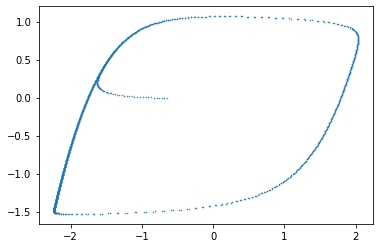

In [67]:
plt.plot(srk[:,0], srk[:,1],'.',markersize=1)

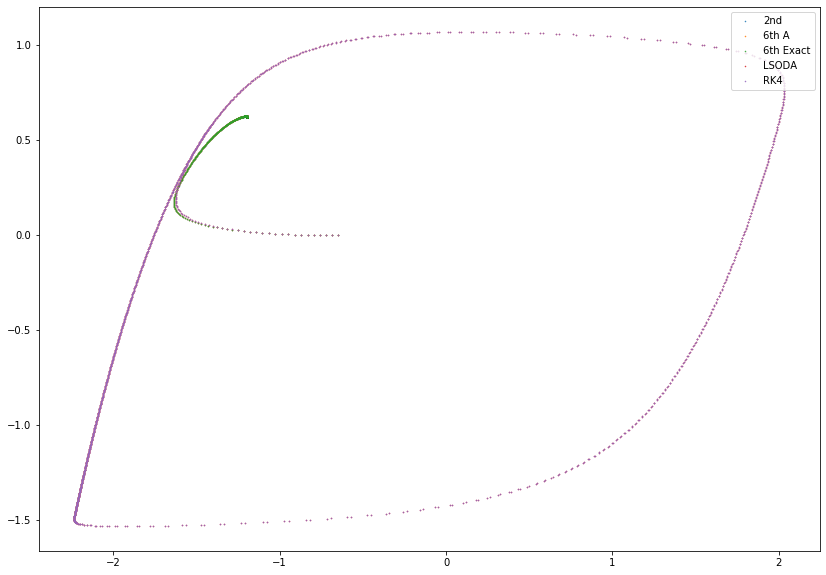

In [66]:
plt.figure(figsize=(14,10))
plt.plot(sol[:,1], frinag.qstoy(sol[:,1],sols), '.',markersize=1,label="2nd")
plt.plot(solm[:,1], frinag.qstoy(solm[:,1],solms),'.',markersize=1,label="6th A")
plt.plot(sol1[:,1], frinag.qstoy(sol1[:,1],sol1s),'.',markersize=1,label="6th Exact")
plt.plot(y_odeint[:, 0], y_odeint[:, 1], '.',markersize=1,label="LSODA")
plt.plot(srk[:,0], srk[:,1],'.',markersize=1,label="RK4")

plt.legend(loc="upper right")
plt.show()

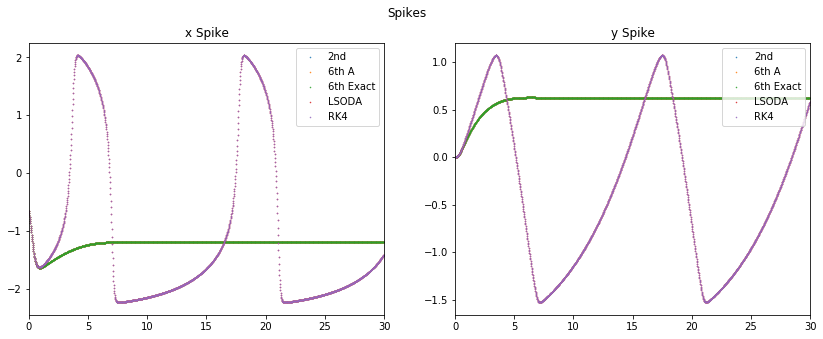

In [69]:
plt.figure(figsize=(14,5))
plt.suptitle("Spikes")
plt.subplot(121)
plt.gca().set_title("x Spike")
plt.plot(tspan, sol[:,1], '.',markersize=1,label="2nd")
plt.plot(tspan, solm[:,1],'.',markersize=1,label="6th A")
plt.plot(tspan, sol1[:,1],'.',markersize=1,label="6th Exact")
plt.plot(tspan, y_odeint[:, 0], '.',markersize=1,label="LSODA")
plt.plot(tspan, srk[:,0],'.',markersize=1,label="RK4")
plt.xlim((0,30))
plt.legend(loc="upper right")

plt.subplot(122)
plt.gca().set_title("y Spike")
plt.plot(tspan, frinag.qstoy(sol[:,1],sols), '.',markersize=1,label="2nd")
plt.plot(tspan, frinag.qstoy(solm[:,1],solms),'.',markersize=1,label="6th A")
plt.plot(tspan, frinag.qstoy(sol1[:,1],sol1s),'.',markersize=1,label="6th Exact")
plt.plot(tspan, y_odeint[:, 1], '.',markersize=1,label="LSODA")
plt.plot(tspan, srk[:,1],'.',markersize=1,label="RK4")
plt.xlim((0,30))
plt.legend(loc="upper right")

plt.show()

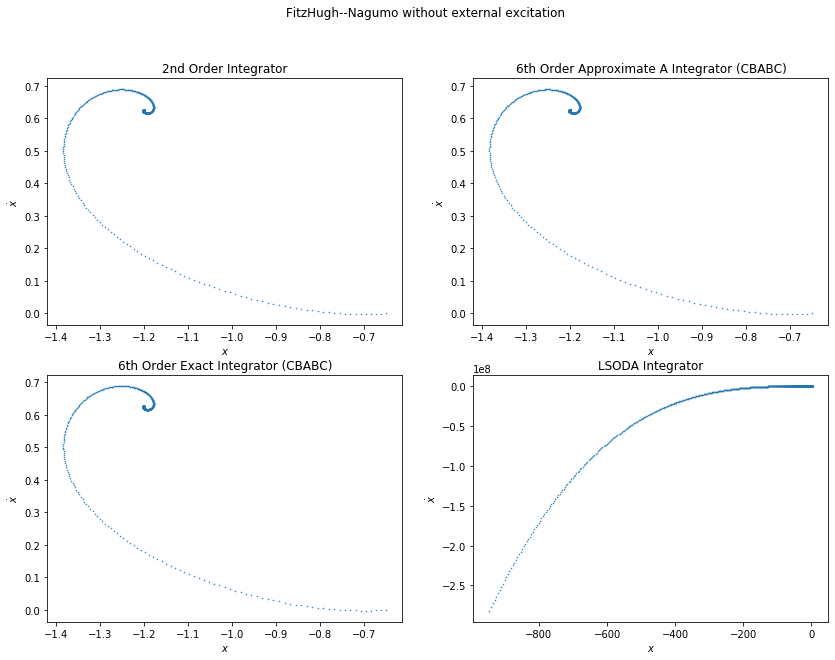

In [44]:
plt.figure(figsize=(14,10))

plt.suptitle("FitzHugh--Nagumo without external excitation")
plt.subplot(221)
plt.gca().set_title("2nd Order Integrator")
plt.plot(sol[:,1], frinag.qstoy(sol[:,1],sols), '.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.subplot(222)
plt.gca().set_title("6th Order Approximate A Integrator (CBABC)")
plt.plot(solm[:,1], frinag.qstoy(solm[:,1],solms),'.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.subplot(223)
plt.gca().set_title("6th Order Exact Integrator (CBABC)")
plt.plot(sol1[:,1], frinag.qstoy(sol1[:,1],sol1s),'.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.subplot(224)
plt.gca().set_title("LSODA Integrator")
plt.plot(y_odeint[:, 0], y_odeint[:, 1], '.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.show()

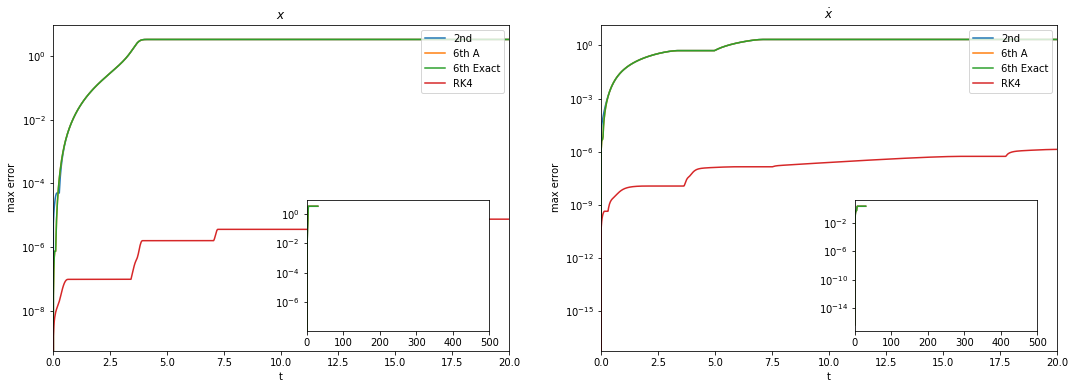

In [70]:
fig = plt.figure(figsize=(18,6))

ax = fig.add_subplot("121")
ax.title.set_text("$x$")
ax.set_xlabel("t")
ax.set_ylabel("max error")
ax.plot(tspan,
         err(sol[:,1],y_odeint[:,0]),label='2nd')
ax.plot(tspan,
         err(solm[:,1],y_odeint[:,0]),label="6th A")
ax.plot(tspan,
         err(sol1[:,1],y_odeint[:,0]),label="6th Exact")
ax.plot(tspan,
        err(srk[:,0],y_odeint[:,0]),label="RK4")
ax.set_yscale('log')
ax.set_xlim(0,20)
ax.legend(loc='upper right')

axins = inset_axes(ax, width="40%", height="40%", loc=4, borderpad=2)
axins.plot(tspan,
         err(sol[:,1],y_odeint[:,0]),markersize=1,label="2nd")
axins.plot(tspan,
         err(solm[:,1],y_odeint[:,0]),markersize=1,label="6th A")
axins.plot(tspan,
         err(sol1[:,1],y_odeint[:,0]),markersize=1,label="6th Exact")
axins.set_yscale('log')
axins.set_xlim(0,500)

ax = fig.add_subplot("122")
ax.title.set_text("$\dot{x}$")
ax.set_xlabel("t")
ax.set_ylabel("max error")
ax.plot(tspan,
         err(frinag.qstoy(sol[:,1],sols),y_odeint[:,1]),label="2nd")
ax.plot(tspan,
         err(frinag.qstoy(solm[:,1],solms),y_odeint[:,1]),label="6th A")
ax.plot(tspan,
         err(frinag.qstoy(sol1[:,1],sol1s),y_odeint[:,1]),label="6th Exact")
ax.plot(tspan,
        err(srk[:,1],y_odeint[:,1]),label="RK4")
ax.set_yscale('log')
ax.set_xlim(0,20)
ax.legend(loc='upper right')

axins = inset_axes(ax, width="40%", height="40%", loc=4, borderpad = 2)
axins.plot(tspan,
         err(frinag.qstoy(sol[:,1],sols),y_odeint[:,1]),markersize=1,label="2nd")
axins.plot(tspan,
         err(frinag.qstoy(solm[:,1],solms),y_odeint[:,1]),markersize=1,label="6th A")
axins.plot(tspan,
         err(frinag.qstoy(sol1[:,1],sol1s),y_odeint[:,1]),markersize=1,label="6th Exact")
axins.set_yscale('log')
axins.set_xlim(0,500)

plt.show()

## Fritzhugh-Nagumo with square pulse excitation

In [29]:
tspan = np.arange(0, 500, 0.02)

a,b,c, i0=0.7,0.8,3.0,-0.4
x0,y0=-0.650,0

def square_pulse(t):
    return i0*np.heaviside(t,0)-i0*np.heaviside(t-100,0)

In [30]:
y_init, params = [x0, y0], (a,b,c)

y_odeint, info = si.odeint(ivp_neu(square_pulse), y_init, tspan, params, rtol=1e-13, atol=1e-15, full_output=True)
print("Number of function evaluations: %d, number of Jacobian evaluations: %d" % (info['nfe'][-1], info['nje'][-1]))

Number of function evaluations: 218103, number of Jacobian evaluations: 4909


In [31]:
frinag=lm.FitzHughNagumo(a,b,c,square_pulse)

q0,p0,s0=x0, 0, frinag.xytos(x0,y0,0)

In [32]:
sol, sols, _ = ic.integrate(li.step1, frinag, tspan, p0, q0, s0)
solm, solms, _ = ic.integrate(step6, frinag, tspan, p0, q0, s0)
sol1, sol1s, _ = ic.integrate(step6e, frinag, tspan, p0, q0, s0)

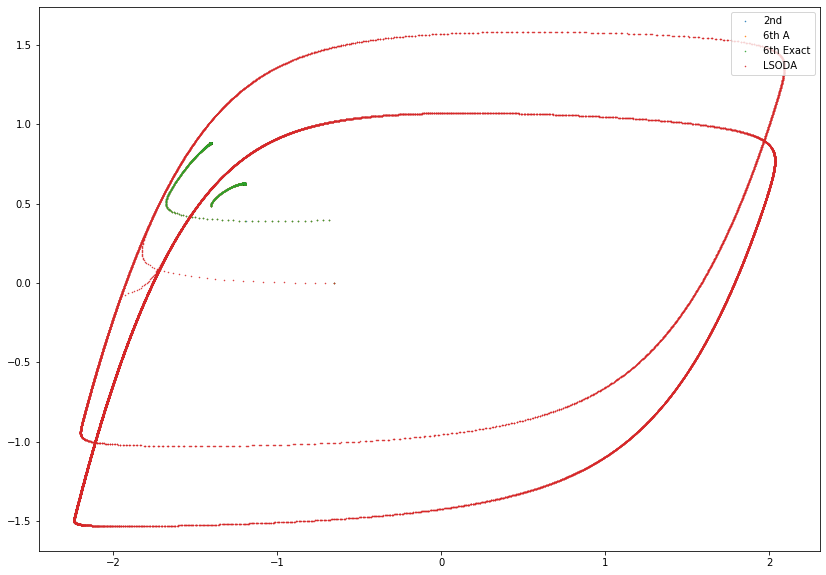

In [33]:
plt.figure(figsize=(14,10))
plt.plot(sol[:,1], (frinag.qstoy(sol[:,1],sols,tspan)), '.',markersize=1,label="2nd")
plt.plot(solm[:,1], (frinag.qstoy(solm[:,1],solms,tspan)),'.',markersize=1,label="6th A")
plt.plot(sol1[:,1], (frinag.qstoy(sol1[:,1],sol1s,tspan)),'.',markersize=1,label="6th Exact")
plt.plot(y_odeint[:, 0], y_odeint[:, 1], '.',markersize=1,label="LSODA")
plt.legend(loc="upper right")
plt.show()

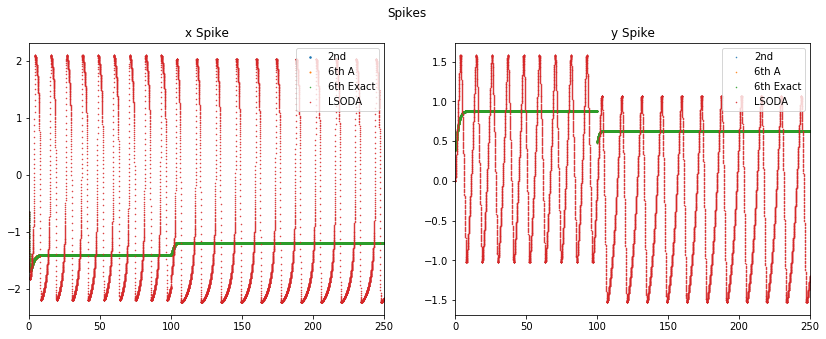

In [34]:
plt.figure(figsize=(14,5))
plt.suptitle("Spikes")
plt.subplot(121)
plt.gca().set_title("x Spike")
plt.plot(tspan, sol[:,1], '.',markersize=3,label="2nd")
plt.plot(tspan, solm[:,1],'.',markersize=2,label="6th A")
plt.plot(tspan, sol1[:,1],'.',markersize=1,label="6th Exact")
plt.plot(tspan, y_odeint[:, 0], '.',markersize=1,label="LSODA")
plt.xlim((0,250))
plt.legend(loc="upper right")

plt.subplot(122)
plt.gca().set_title("y Spike")
plt.plot(tspan, frinag.qstoy(sol[:,1],sols,tspan), '.',markersize=1,label="2nd")
plt.plot(tspan, frinag.qstoy(solm[:,1],solms,tspan),'.',markersize=1,label="6th A")
plt.plot(tspan, frinag.qstoy(sol1[:,1],sol1s,tspan),'.',markersize=1,label="6th Exact")
plt.plot(tspan, y_odeint[:, 1], '.',markersize=1,label="LSODA")
plt.xlim((0,250))
plt.legend(loc="upper right")

plt.show()

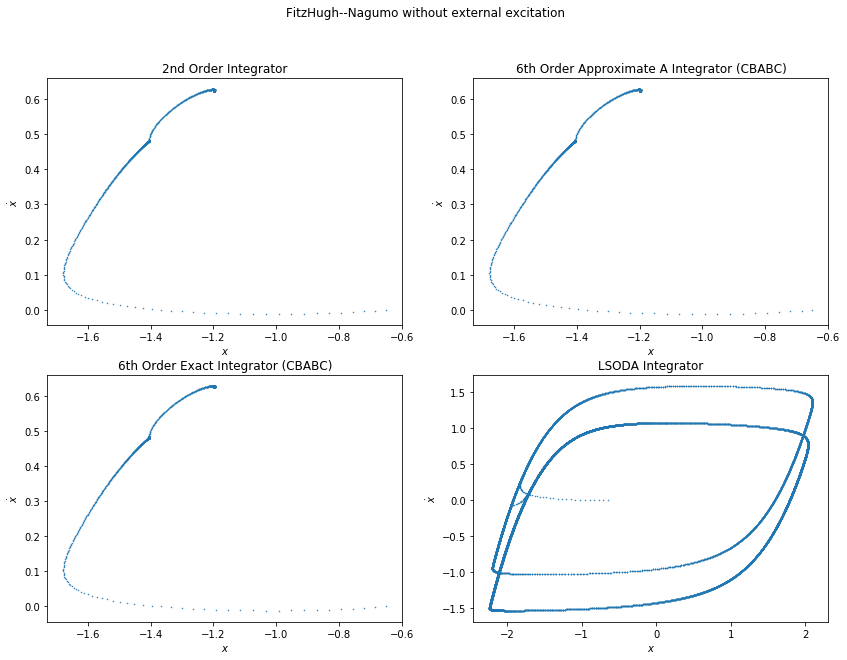

In [35]:
plt.figure(figsize=(14,10))

plt.suptitle("FitzHugh--Nagumo without external excitation")
plt.subplot(221)
plt.gca().set_title("2nd Order Integrator")
plt.plot(sol[:,1], frinag.qstoy(sol[:,1],sols), '.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.subplot(222)
plt.gca().set_title("6th Order Approximate A Integrator (CBABC)")
plt.plot(solm[:,1], frinag.qstoy(solm[:,1],solms),'.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.subplot(223)
plt.gca().set_title("6th Order Exact Integrator (CBABC)")
plt.plot(sol1[:,1], frinag.qstoy(sol1[:,1],sol1s),'.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.subplot(224)
plt.gca().set_title("LSODA Integrator")
plt.plot(y_odeint[:, 0], y_odeint[:, 1], '.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.show()

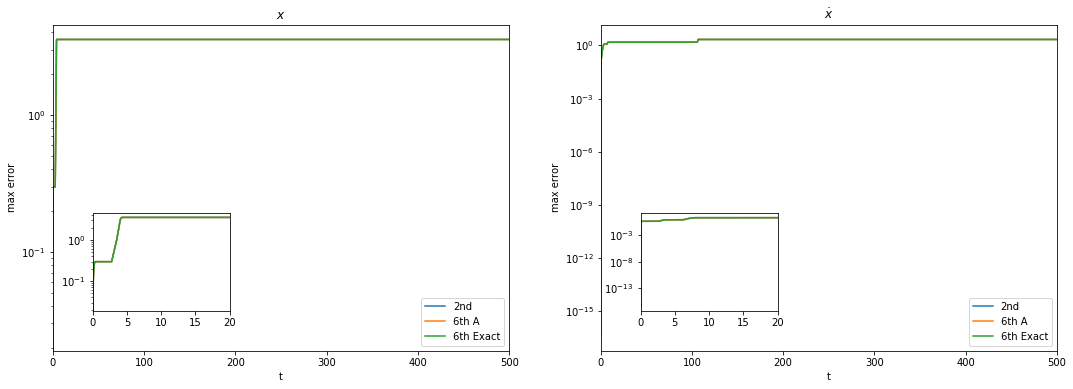

In [36]:
fig = plt.figure(figsize=(18,6))

ax = fig.add_subplot("121")
ax.title.set_text("$x$")
ax.set_xlabel("t")
ax.set_ylabel("max error")
ax.plot(tspan,
         err(sol[:,1],y_odeint[:,0]),label='2nd')
ax.plot(tspan,
         err(solm[:,1],y_odeint[:,0]),label="6th A")
ax.plot(tspan,
         err(sol1[:,1],y_odeint[:,0]),label="6th Exact")
ax.set_yscale('log')
ax.set_xlim(0,500)
ax.legend(loc='lower right')

axins = inset_axes(ax, width="30%", height="30%", loc=3, borderpad=4)
axins.plot(tspan,
         err(sol[:,1],y_odeint[:,0]),markersize=1,label="2nd")
axins.plot(tspan,
         err(solm[:,1],y_odeint[:,0]),markersize=1,label="6th A")
axins.plot(tspan,
         err(sol1[:,1],y_odeint[:,0]),markersize=1,label="6th Exact")
axins.set_yscale('log')
axins.set_xlim(0,20)

ax = fig.add_subplot("122")
ax.title.set_text("$\dot{x}$")
ax.set_xlabel("t")
ax.set_ylabel("max error")
ax.plot(tspan,
         err(frinag.qstoy(sol[:,1],sols),y_odeint[:,1]),label="2nd")
ax.plot(tspan,
         err(frinag.qstoy(solm[:,1],solms),y_odeint[:,1]),label="6th A")
ax.plot(tspan,
         err(frinag.qstoy(sol1[:,1],sol1s),y_odeint[:,1]),label="6th Exact")
ax.set_yscale('log')
ax.set_xlim(0,500)
ax.legend(loc='lower right')

axins = inset_axes(ax, width="30%", height="30%", loc=3, borderpad=4)
axins.plot(tspan,
         err(frinag.qstoy(sol[:,1],sols,tspan),y_odeint[:,1]),markersize=1,label="2nd")
axins.plot(tspan,
         err(frinag.qstoy(solm[:,1],solms,tspan),y_odeint[:,1]),markersize=1,label="6th A")
axins.plot(tspan,
         err(frinag.qstoy(sol1[:,1],sol1s,tspan),y_odeint[:,1]),markersize=1,label="6th Exact")
axins.set_yscale('log')
axins.set_xlim(0,20)

plt.show()